In [18]:
%reload_ext autoreload
%autoreload 2
%matplotlib widget

[autoreload of bnn.optimizer failed: Traceback (most recent call last):
  File "/home/blustrini/miniconda3/envs/bnn/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/blustrini/miniconda3/envs/bnn/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/home/blustrini/miniconda3/envs/bnn/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/home/blustrini/miniconda3/envs/bnn/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 349, in update_class
    if update_generic(old_obj, new_obj):
       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/blustrini/miniconda3/envs/bnn/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/home/blustrini/miniconda3/envs/bnn/lib/python3.11/site-p

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm

In [20]:
import bnn.data
import bnn.functions
import bnn.layer
import bnn.loss
import bnn.network
import bnn.optimizer

In [21]:
forward_func = bnn.functions.forward.SignBinarise()
#forward_func=bnn.functions.forward.LayerMeanBinarise()
#forward_func=bnn.functions.forward.LayerMedianBinarise()

In [22]:
#backward_func = bnn.functions.backward.SignTernarise()
#backward_func = bnn.functions.backward.LayerMeanStdTernarise(half_range_stds=0.5)
backward_func = bnn.functions.backward.LayerQuantileTernarise(lo=0.25, hi=0.75)

In [23]:
INPUT_DIM = 1
OUTPUT_DIM = 4

In [24]:
dims = [INPUT_DIM, 100, 100, OUTPUT_DIM]
TBNN = bnn.network.TernBinNetwork(
    *dims,
    forward_func=forward_func,
    backward_func=backward_func,
)
TBNN._initialise(W_mean=0, W_zero_prob=0.5)

In [25]:
target_dims = [INPUT_DIM, 10, OUTPUT_DIM]
Target_TBNN = bnn.network.TernBinNetwork(
    *target_dims,
    forward_func=forward_func,
    backward_func=None,
)
Target_TBNN._initialise(W_mean=0, W_zero_prob=0.8)

In [26]:
TN_DL = bnn.data.TargetNetworkDataLoader(
    target_network=Target_TBNN,
    datapoints=1000,
    batch_size=1000,
    include_last_if_uneven=True,
)

UnaryDL = bnn.data.AllUnaryFunctionsDataLoader(
    input_dim=1,
    datapoints=100,
    batch_size=100,
    include_last_if_uneven=True
)

DL = UnaryDL

In [27]:
loss_func: bnn.loss.LossFunction = bnn.loss.l1

In [28]:
BernOpt = bnn.optimizer.ExpectationSGD(TBNN.parameters(), lr=0.001)

In [29]:
losses = []

In [30]:
train_epochs = 500
num_logs = 10
epoch_log_rate = train_epochs // num_logs

In [31]:
for epoch in tqdm.trange(train_epochs):
    epoch_loss = 0
    for batch in DL:
        # forward pass and loss
        output = TBNN.forward(batch.input)
        loss = loss_func.forward(output=output, target=batch.target)

        # backward pass
        grad = loss_func.backward(output=output, target=batch.target)
        out_grad = TBNN.backward(grad)

        # optimizer step
        BernOpt.step()

        # sum loss
        epoch_loss += loss

    # save loss
    losses.append(epoch_loss)

    early_exit = epoch_loss == 0
    if early_exit or (epoch % epoch_log_rate) == 0:
        print(f'epoch: {epoch}\tloss: {loss}')

    if early_exit:
        break

  1%|          | 4/500 [00:00<00:19, 25.41it/s]

epoch: 0	loss: 376
epoch: 4	loss: 0


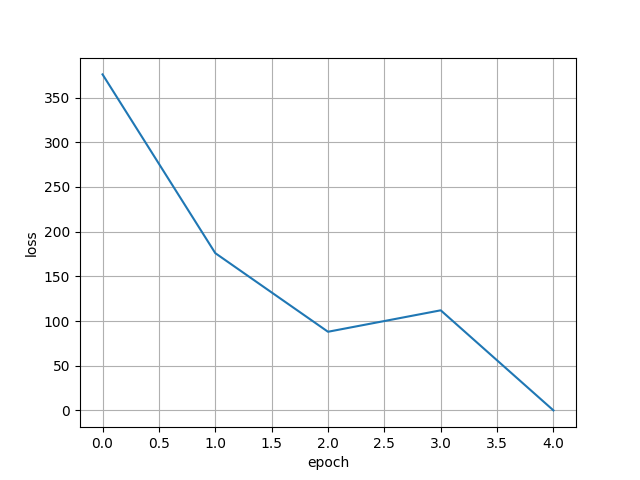

In [32]:
NAME = 'loss_curve_partial'
plt.close(NAME)
plt.figure(NAME)

plt.plot(losses[:train_epochs])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

plt.show()

In [33]:
for name, p in TBNN.named_parameters():
    if name.lower().endswith('.w'):
        print(name, '\n', p, '\n', p.grad)

layers.TernBinLayer0.W 
 Parameter containing:
tensor([[-1,  0,  0, -1, -1, -1,  0,  0,  0,  1,  0,  0,  0,  0, -1,  0, -1,  0,
         -1,  0,  0,  0,  0,  0, -1, -1,  0, -1,  1,  0,  1,  0, -1,  0, -1,  1,
          0, -1,  0, -1,  0,  1,  0, -1,  1, -1,  1,  0, -1,  1,  1,  0,  1,  1,
         -1,  1,  0,  1, -1,  1,  0,  0,  0,  0, -1,  1, -1,  0,  0,  0,  1,  0,
         -1,  0,  0,  0,  0, -1,  0,  0,  0,  0,  1,  0,  0,  0,  1,  1,  0,  0,
          1,  0, -1,  0,  1,  0,  0, -1,  0,  0]], dtype=torch.int32) 
 tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]], dtype=torch.int32)
layers.TernBinLayer1.W 
 Parameter containing:
tensor([[ 0,  0,  0,  ...,  0,  0,  0],
        [-1, -1,  0,  .

In [34]:
assert bnn.network.network_params_al_ternary(TBNN)